# Импортируем библиотеки

In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#mean_absolute_percentage_error нет в sklearn 0.22, поэтому напишем сами:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true+1)))

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

import xgboost as xgb
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

np.random.seed(42)

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.shape

(377185, 18)

Количество пропущенных значенний:

In [5]:
df.isna().sum() / (df.shape[0])*100 #процент пропусков

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Удаляем строки без целевой переменной:

In [6]:
df = df.loc[df['target'].isna() == False]

In [7]:
df.shape

(374704, 18)

Очищаем целевую переменную:

In [8]:
def target_format(target):
    target = re.sub('[^0-9]', '', target) #оставляем только цифры
    target = int(target)
    return target

In [9]:
df['target'] = df['target'].apply(target_format)
df['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Очищаем признаки:

In [10]:
# Преобразовываем в действительные числа
def features_float_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('1 1/2', '1.5', feature) # заменяем 1 1/2 на 1.5 (признак stories)
    feature = re.sub('[^0-9,\.]', '', feature) # оставляем только цифры
    feature = re.sub(',', '.', feature) # заменяем ',' на '.'
    
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем площадь
def sqft_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('[^0-9\.]', '', feature) # оставляем только цифры
   
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем статус
def status_format(status):
    status = status.lower()
    # если дом ещё не сделан,оставляем только 'coming soon', дату удаляем
    if status.startswith('coming soon'): 
        status = 'coming soon'
        
    status = re.sub('[^a-z]', ' ', status) # оставляем только буквы
    status = re.sub(r'\b\w{,2}\b', '', status) # удаляем сочетание из 1 и 2 букв
    status = re.sub(r'\s+', '', status) # заменяем 1 или более пробелов на ''
    if status == 'active' or status == 'for sale': # бóльшая часть домов - for sale или active
        status = 1
    else:
        status = 0
    return status
#Преобразовываем фичу камина
def fireplace_format(fireplace):
    if fireplace == 0:
        return fireplace
    fireplace = fireplace.lower()
    
    if fireplace.count('no')>0:
        fireplace = 0
    else:
        fireplace = 1
    return fireplace

In [11]:
dummy_features = ['status','state']  
drop_features = ['street', 'mls-id', 'MlsId', 'schools', 'homeFacts', 'city', 'zipcode'] 

#### Status

In [12]:
df.status.value_counts()

for sale                  156100
Active                    105206
For sale                   43465
foreclosure                 5677
New construction            5459
                           ...  
Contract                       1
Backup                         1
Pending Backups Wanted         1
Coming soon: Oct 21.           1
Pending Take Backups           1
Name: status, Length: 156, dtype: int64

Приблизительно 80% домов - ```for sale``` или ```for sale```, поэтому вместо них ставим ```1```, иначе ```0```
(заполняем пропуски на пустые строки, и применяем ```status_format```):

In [13]:
df['status'] = df['status'].fillna('')
df['status'] = df['status'].apply(status_format)

#### Property Type

In [14]:
df.propertyType.value_counts()

single-family home                  91376
Single Family                       61888
Single Family Home                  31725
condo                               25878
lot/land                            20532
                                    ...  
2 Stories, Colonial, Traditional        1
Back-to-Back                            1
Bungalow, Craftsman, Farm House         1
Cape Cod, Williamsburg, Cottage         1
Mid Rise                                1
Name: propertyType, Length: 1279, dtype: int64

Приблизительно 50% домов - ```single family```, поэтому оставляем только этот признак:

In [15]:
def propertyType_format(propertyType):
    propertyType = propertyType.lower()
    propertyType = re.sub('[^a-z]', ' ', propertyType)# оставляем только буквы
    
    # если начинается на 'single family' - ставим 1, иначе 0
    if propertyType.startswith('single family'): 
        propertyType = 1 
    else:
        propertyType = 0
    return propertyType

In [16]:
df['propertyType'] = df['propertyType'].fillna('')
df['propertyType'] = df['propertyType'].apply(propertyType_format)

#### Private pool
Вместо пропусков ставим ```no```, заполняем вместо ```yes``` - 1, вместо ```no``` - 0

In [17]:
df['private pool'] = df['private pool'].fillna('no')
df['private pool'] = df['private pool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['PrivatePool'].fillna('no')
df['PrivatePool'] = df['PrivatePool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis=1, inplace=True)

#### Baths, sqft, beds, stories, fireplace
Заполняем пропуски нулями.
К ```Baths, beds, stories``` применяем ```features_float_format```, к ```sqft - sqft_format```, а к ```fireplace``` - ```fireplace_format```:

In [18]:
df['baths'] = df['baths'].fillna(0)
df['baths'] = df['baths'].apply(features_float_format)

df['sqft'] = df['sqft'].fillna(0)
df['sqft'] = df['sqft'].apply(sqft_format)

df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].apply(features_float_format)

df['stories'] = df['stories'].fillna(0)
df['stories'] = df['stories'].apply(features_float_format)

df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(fireplace_format)

#### Year Built

In [19]:
df['homeFacts'] = df['homeFacts'].apply(eval) # конвертируем строку в словарь, используя eval

Нужное нам значение хранится в первом словаре, который хранится в списке, который, в свою очередь, хранится в словаре с ключом ```atAGlanceFacts```:

In [20]:
M = df['homeFacts'][0]
print(M,'\n')
print(M['atAGlanceFacts'],'\n')
print(M['atAGlanceFacts'][0],'\n')
print(M['atAGlanceFacts'][0]['factValue'])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]} 

[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}] 

{'factValue': '2019', 'factLabel': 'Year built'} 

2019


In [21]:
def yearBuilt_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём первый елемент списка
    homeFacts = homeFacts[0]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Year built':
        homeFacts = homeFacts.get('factValue')
    # если homeFacts - число, то выводим его, иначе 0
    try:
        homeFacts = int(homeFacts)
    except:
        homeFacts = 0
    return homeFacts

In [22]:
df['yearBuilt'] = df['homeFacts'].apply(yearBuilt_format)

#### Heating

In [23]:
def heating_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём третий елемент списка
    homeFacts = homeFacts[2]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Heating':
        homeFacts = homeFacts.get('factValue')
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что в доме нет отопления
        return 0
    else:
        return 1

In [24]:
df['heating'] = df['homeFacts'].apply(heating_format)

#### Parking

In [25]:
def parking_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём пятый елемент списка
    homeFacts = homeFacts[4]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Parking':
        homeFacts = homeFacts.get('factValue')
        homeFacts = str(homeFacts).lower()
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что участке нет парковки
        homeFacts = 0
    else:
        homeFacts = re.sub('[^0-9]', '', homeFacts) # оставляем только цифры
        try:
            homeFacts = int(homeFacts)
            
        # Если homeFacts - строка ('Attached Garage'), считаем, что в доме 1 парковка
        except:
            homeFacts = 1
    return homeFacts

In [26]:
df['parking'] = df['homeFacts'].apply(parking_format)

#### Lot size

In [27]:
def lotsize_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём шестой елемент списка
    homeFacts = homeFacts[5]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'lotsize':
        homeFacts = str(homeFacts.get('factValue'))
        
    if homeFacts == 0:
        return homeFacts
    homeFacts = homeFacts.replace('Sq. Ft.','')
    homeFacts = re.sub('[^0-9\.]', '', homeFacts) # оставляем только цифры
   
    try:
        homeFacts = float(homeFacts)
    #если homeFacts - пустая строка, возвращаем 0
    except:
        homeFacts = 0
    if homeFacts < 10: # если homeFacts подано в акрах
        homeFacts *= 43560
    return homeFacts

In [28]:
df['lotsize'] = df['homeFacts'].apply(lotsize_format)

#### Schools rating

In [29]:
df['schools'] = df['schools'].apply(eval) # конвертируем строку в словарь, используя eval

Список с рейтингами школ хранится в словаре, который хранится в списке:

In [30]:
M = df['schools'][0]
print(M,'\n')
print(M[0],'\n')
print(M[0]['rating'])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}] 

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']} 

['4', '4', '

In [31]:
def rating_format(schools):
    # если schools - непустой словарь, берём значение 'rating', иначе 0
    schools = schools[0]
    schools = schools.get('rating', 0)
    if schools == 0: 
        return 0
    
    rating = []
    for x in schools:
        x = re.sub('/10','',x) # если рейтинг записан в формате 'x/10', заменяем на 'x'
        rating.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое рейтингов
    return np.mean(rating)

Применяем ```rating_format```, если результат - ```nan```, заменяем на ```0```:

In [32]:
df['rating'] = df['schools'].apply(rating_format)
df['rating'] = df['rating'].fillna(0)

C:\Users\andru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.



#### Distance
По аналогии с ```rating```, выбираем значение из списка словарей и ищем среднее арифметическое расстояний

In [33]:
def distance_format(schools):
    # если schools - непустой словарь, берём значение 'data', иначе 0
    schools = schools[0]
    schools = schools.get('data', 0)
    if schools == 0: 
        return 0
    # если schools - непустой словарь, берём значение 'distance', иначе 0
    schools = schools.get('Distance', 0)
    if schools == 0: 
        return 0
    
    distance=[]
    for x in schools:
        distance.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое расстояний
    return np.mean(distance)

Применяем ```distance_format``` и заполняем пропуски нулями:

In [34]:
df['distance'] = df['schools'].apply(distance_format)
df['distance'] = df['distance'].fillna(0)

Удаляем ненужные фичи:

In [35]:
df.drop(drop_features, axis=1, inplace=True)

#### State 
Штаты - dummy-features, поэтому применяем к ```df['state']``` функцию ```pd.get_dummies``` ,и конкатенируем результат к датасету:

In [36]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)
df.drop('state', axis=1, inplace=True)

##### Итог:
Мы предобработали и очистили данные, и получили 8 числовых и 43 dummy признака.

# Статистический анализ

In [37]:
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,1,1,3.5,1,2900.0,4.0,0.0,0,418000,2019,...,0,0,0,0,0,0,0,0,0,0
1,0,1,3.0,0,1947.0,3.0,2.0,0,310000,2019,...,0,0,0,0,0,0,0,0,1,0
2,0,1,2.0,1,3000.0,3.0,1.0,1,2895000,1961,...,0,0,0,0,0,0,0,0,0,0
3,0,1,8.0,1,6457.0,5.0,3.0,0,2395000,2006,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0.0,0,0.0,0.0,0.0,0,5000,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df.describe(include='all')

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
count,374704.000000,374704.000000,3.747040e+05,374704.000000,3.747040e+05,374704.000000,374704.000000,374704.000000,3.747040e+05,3.747040e+05,...,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000
mean,0.281953,0.493694,3.718902e+02,0.267360,5.921395e+03,2.417060,1.101108,0.118152,6.447575e+05,2.990621e+06,...,0.000003,0.014705,0.000075,0.048654,0.222464,0.003525,0.002135,0.002306,0.036666,0.001206
std,0.449951,0.499961,1.928389e+05,0.442583,1.499304e+06,3.936648,3.432640,0.322788,1.841431e+06,1.293752e+09,...,0.001634,0.120369,0.008644,0.215145,0.415901,0.059271,0.046157,0.047964,0.187941,0.034711
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,1.035000e+03,0.000000,0.000000,0.000000,1.869900e+05,1.926000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000e+00,0.000000,1.656000e+03,3.000000,1.000000,0.000000,3.200000e+05,1.974000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000e+00,1.000000,2.458000e+03,4.000000,2.000000,0.000000,5.821000e+05,2.005000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.161161e+08,1.000000,7.959794e+08,871.000000,1120.000000,1.000000,1.950000e+08,5.599906e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим матрицу корреляций:

In [39]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

Избыточной кореляции между признаками нету, значит никаких признаков удалять ненужно. 
Построим гистограмы с различными признаками:

Построим гистограмму логарифма целевой переменной:

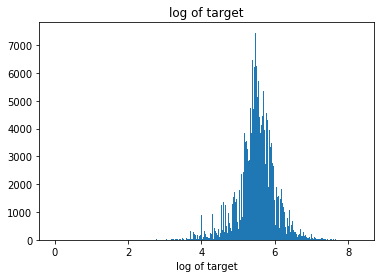

In [40]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Отсюда видно, что существует пик в точке 5.5, а распределение - похоже на нормальное.

Построим гистограмму логарифма площади, если площадь не равна ```0```:

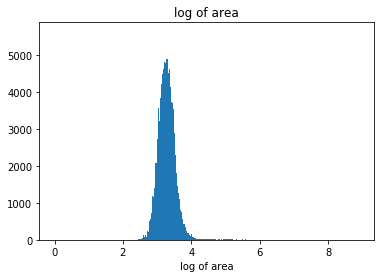

In [41]:
_ = plt.hist(np.log10(df.loc[df['sqft']>0]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Видно пика около 3. Значит, большинство значенний площади находятся на промежутке от около ```1000``` до ```10000```:

Построим гистограмму распределений кроватей, убрав объекты, где количество кроватей меньше ```15```:

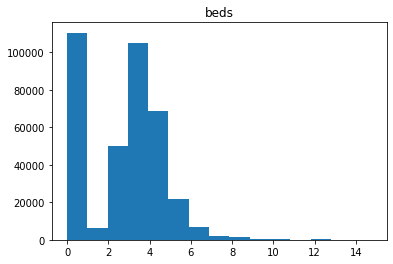

In [42]:
_ = plt.hist(df[df['beds']<15]['beds'],bins = 15)
plt.title('beds')
plt.show()

Распределение похоже на нормальное(не считая значенний = 0).

Построим гистограмму распределений логарифма lot siz'а:

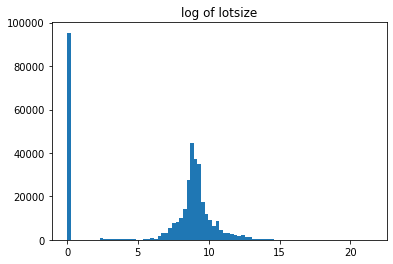

In [43]:
_ = plt.hist(np.log(df['lotsize']+1),bins='auto')
plt.title('log of lotsize')
plt.show()

Распределение похоже на нормальное(не считая значенний = 0).

Построим гистограмму распределений логарифма этажей, убрав объекты, где количество этажей больше 0:

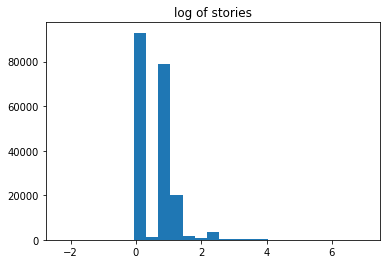

In [44]:
_ = plt.hist(np.log(df.loc[df.stories > 0]['stories']),bins=25)
plt.title('log of stories')
plt.show()

Распределение похоже на нормальное(не считая значенний = 0).

Построим гистограмму распределений рейтинга школ:

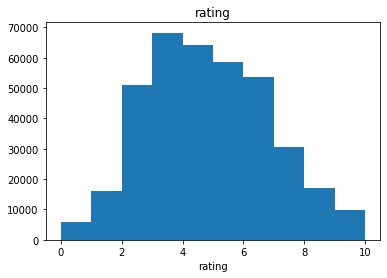

In [45]:
_ = plt.hist(df['rating'],bins = 10)
plt.title('rating')
plt.xlabel('rating')
plt.show()

Построим гистограмму логарифма расстояний:

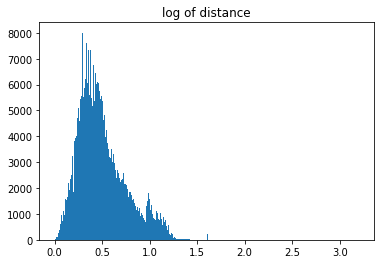

In [46]:
_ = plt.hist(np.log10(df['distance']+1),bins = 'auto')
plt.title('log of distance')
plt.show()

Построим гистограмму распределений ванных, убрав объекты, где количество ванных больше 20 или равно 0:

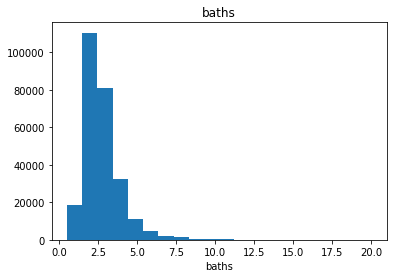

In [47]:
_ = plt.hist(df.loc[(df['baths'] !=0) & (df['baths'] <= 20)]['baths'],bins = 20)
plt.title('baths')
plt.xlabel('baths')
plt.show()

Построим гистограмму распределений года постройки, убрав шумы(меньше 1875 или больше 2020):

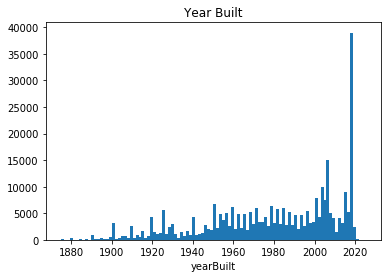

In [48]:
_ = plt.hist(df.loc[(df['yearBuilt'] >= 1875) & (df['yearBuilt'] <= 2100)]['yearBuilt'],bins = 'auto')
plt.title('Year Built')
plt.xlabel('yearBuilt')
plt.show()

###### Точечные диаграммы целевой переменной и признаков

Построим точечную диаграмму целевой переменной и рейтинга школ:

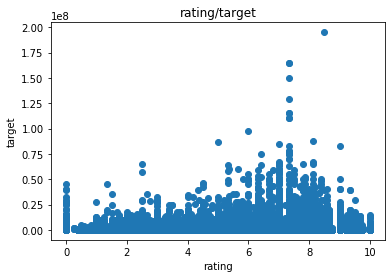

In [49]:
_ = plt.scatter(df['rating'],df['target'])

plt.title('rating/target')
plt.xlabel('rating')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и логарифма расстояний до школ:

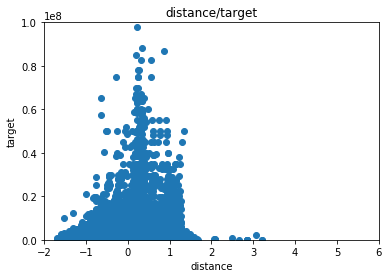

In [50]:
_ = plt.scatter(np.log10(df.loc[df['distance']>0]['distance']),df.loc[df['distance']>0]['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-2,6)
plt.ylim(-100,1e8)

plt.title('distance/target')
plt.xlabel('distance')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма количества этажей:

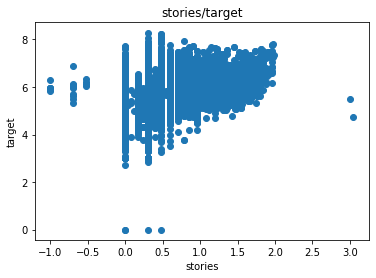

In [51]:
M = df.loc[(df['stories']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['stories']),
                np.log10(M['target']))

plt.title('stories/target')
plt.xlabel('stories')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества кроватей:

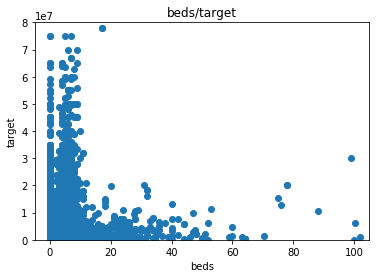

In [52]:
_ = plt.scatter(df['beds'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-5,105)
plt.ylim(-10,1e7*8)

plt.title('beds/target')
plt.xlabel('beds')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и года постройки:

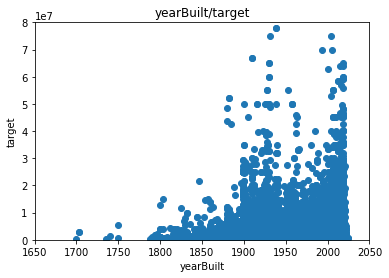

In [53]:
_ = plt.scatter(df['yearBuilt'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(1650,2050)
plt.ylim(-50,8*1e7)

plt.title('yearBuilt/target')
plt.xlabel('yearBuilt')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма площади:

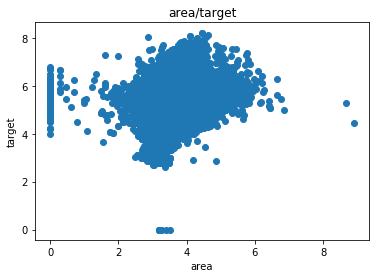

In [54]:
M = df.loc[(df['sqft']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['sqft']),
                np.log10(M['target']))

plt.title('area/target')
plt.xlabel('area')
plt.ylabel('target')

plt.show()

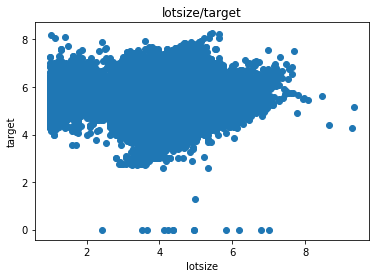

In [55]:
M = df.loc[(df['lotsize']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['lotsize']),
                np.log10(M['target']))

plt.title('lotsize/target')
plt.xlabel('lotsize')
plt.ylabel('target')

plt.show()

Поскольку распределения логарифма целевой переменной, логарифма количества этажей, логарифма lotsiz'а, логарифма площади и логарифма расстояний до школ - похожы на нормальные, то можна к этим признакам применить логарифм:

In [56]:
df = df.loc[(df['sqft']>0) & (df['distance']>0)] # берём только значения больше 0 (log(0)=-inf)
df['sqft'] = df['sqft'].apply(lambda x: np.log10(x))
df['distance'] = df['distance'].apply(lambda x: np.log10(x))
df['stories'] = df['stories'].apply(lambda x: np.log10(x+1))
df['lotsize'] = df['lotsize'].apply(lambda x: np.log10(x+1))

Для ```target``` воспользуемся ```TransformedTargetRegressor```

Разобьем датафрейм на 2: в одном отдельные домы ('single home'), в других - остальные(квартиры, кондоминиумы):

In [57]:
#df = df.loc[df['propertyType']==0]
#df = df.drop('propertyType',axis=1)
df_single = df.loc[df['propertyType'] == 1] # 
df_condo = df.loc[df['propertyType'] == 0]
df_single = df_single.drop('propertyType',axis=1)
df_condo = df_condo.drop('propertyType',axis=1) 

# Построение моделей

Разобьем данные на обучающаю и тестовую выборки:

In [58]:
X_single, y_single = df_single.drop('target', axis = 1), df_single['target']
X_condo, y_condo = df_condo.drop('target', axis = 1), df_condo['target']

In [59]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, test_size=0.2, random_state=42)

X_train_condo, X_test_condo, y_train_condo, y_test_condo = train_test_split(X_condo, y_condo,test_size=0.2, random_state=42)

In [60]:
X_train_single.shape, y_train_single.shape, X_test_single.shape, y_test_single.shape

((145005, 52), (145005,), (36252, 52), (36252,))

In [61]:
X_train_condo.shape, y_train_condo.shape, X_test_condo.shape, y_test_condo.shape

((110390, 52), (110390,), (27598, 52), (27598,))

Сделаем функцию для оценки точности предсказаний:

In [62]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    #делаем предсказание
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    #mse
    print('train mse :', mean_squared_error(y_train, train_predict) )
    print('test mse  :', mean_squared_error(y_test, test_predict) )
    #max error
    print('train max error :', max_error(y_train, train_predict) )
    print('test max error  :', max_error(y_test, test_predict) )
    #MAE
    print('train mean absolute error :', mean_absolute_error(y_train, train_predict) )
    print('test mean absolute error  :', mean_absolute_error(y_test, test_predict) )
    #MAPE
    print('train mean absolute percentage error :', mean_absolute_percentage_error(y_train, train_predict) )
    print('test mean absolute percentage error  :', mean_absolute_percentage_error(y_test, test_predict) )
    #RMSE
    print('train rmse :', np.sqrt(mean_squared_error(y_train, train_predict) ))
    print('test rmse  :',np.sqrt(mean_squared_error(y_test, test_predict) ))
    #Coefficient of determination
    print('train R^2', clf.score(X_train,y_train)) 
    print('test R^2', clf.score(X_test,y_test))

### Линейная регрессия

In [63]:
lr = LinearRegression()
regr =TransformedTargetRegressor(regressor=lr, transformer = PowerTransformer()) # Применяем PowerTransformer к целевой переменной
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer())

In [64]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single) 

train mse : 3.4662335380895007e+20
test mse  : 2038749006105.4102
train max error : 7089578194542.2295
test max error  : 135676519.13444954
train mean absolute error : 49152302.610825285
test mean absolute error  : 270398.7460250926
train mean absolute percentage error : 111.12964710383945
test mean absolute percentage error  : 3.6279538518702474
train rmse : 18617823551.880333
test rmse  : 1427847.6830899753
train R^2 -137387995.38857087
test R^2 0.364791592571593


In [65]:
lr = LinearRegression()
regr =TransformedTargetRegressor(regressor=lr, transformer = PowerTransformer()) # Применяем PowerTransformer к целевой переменной
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer())

In [66]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1650848094485876.8
test mse  : 8.71824039714659e+18
train max error : 13413393140.069134
test max error  : 490515973829.5988
train mean absolute error : 584186.7686385788
test mean absolute error  : 18216342.4567002
train mean absolute percentage error : 4.030509349511544
test mean absolute percentage error  : 16.039488502835468
train rmse : 40630630.00355615
test rmse  : 2952666658.6573215
train R^2 -518.8910313846357
test R^2 -3242857.617407293


Коэффициент детерминации ниже 0.1, а значит модель очень плохо предсказывает результат. Попробуем различные деревья решений:

### Деревья решений

С помощью ```optune``` переберём различные варианты ```max_depth```:

In [67]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 5, 10)
    
    tree = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor=tree, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 7)

[I 2020-09-28 23:36:47,729] A new study created in memory with name: no-name-86fca44e-79d0-4a83-8c7c-bae0369f2389
[I 2020-09-28 23:36:48,978] Trial 0 finished with value: 1398103306753.4136 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 1398103306753.4136.
[I 2020-09-28 23:36:50,045] Trial 1 finished with value: 1398103306753.4136 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 1398103306753.4136.
[I 2020-09-28 23:36:50,965] Trial 2 finished with value: 1695556726362.2944 and parameters: {'tree_max_depth': 5}. Best is trial 0 with value: 1398103306753.4136.
[I 2020-09-28 23:36:52,186] Trial 3 finished with value: 1398103306753.4136 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 1398103306753.4136.
[I 2020-09-28 23:36:53,282] Trial 4 finished with value: 1398103306753.4136 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 1398103306753.4136.
[I 2020-09-28 23:36:54,744] Trial 5 finished with value: 1122990778733.

Итог: при максимальной глубине меньше 5 модель недообучается, а при максимальной глубине больше 5 - переобучается. 

In [68]:
tree = DecisionTreeRegressor(max_depth  = 9 ,random_state = 42)
regr =TransformedTargetRegressor(regressor=tree, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=9,
                                                           random_state=42),
                           transformer=PowerTransformer())

In [69]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 514106199237.4675
test mse  : 1098312781122.3442
train max error : 42180207.75622347
test max error  : 97856770.41212939
train mean absolute error : 222474.48437523155
test mean absolute error  : 245380.18632803828
train mean absolute percentage error : 2.233049784183974
test mean absolute percentage error  : 3.6739045777576833
train rmse : 717011.9937891329
test rmse  : 1048004.1894583935
train R^2 0.796228327179854
test R^2 0.6578011758849547


In [70]:
tree = DecisionTreeRegressor(max_depth  = 9 ,random_state = 42)
regr =TransformedTargetRegressor(regressor=tree, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=9,
                                                           random_state=42),
                           transformer=PowerTransformer())

In [71]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1116118145429.6208
test mse  : 1333701056146.2205
train max error : 61923492.17318923
test max error  : 50568289.18486713
train mean absolute error : 300357.8918592435
test mean absolute error  : 321023.6788675189
train mean absolute percentage error : 2.5133448341877522
test mean absolute percentage error  : 8.811621920052435
train rmse : 1056464.9286320966
test rmse  : 1154859.7560510195
train R^2 0.6485080512781991
test R^2 0.5039132019823038


### Попробуем различные ансамбли:

С помощью ```optune``` переберём различные варианты ```n_estimators```:

In [72]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("rf_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor=bagging_trees, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-09-28 23:36:58,699] A new study created in memory with name: no-name-9fb33b2f-b355-4f45-be93-db7b0ccdf0c5
[I 2020-09-28 23:37:14,420] Trial 0 finished with value: 983808004054.1979 and parameters: {'rf_n_estimators': 19}. Best is trial 0 with value: 983808004054.1979.
[I 2020-09-28 23:37:26,065] Trial 1 finished with value: 998874269175.1636 and parameters: {'rf_n_estimators': 15}. Best is trial 0 with value: 983808004054.1979.
[I 2020-09-28 23:37:40,753] Trial 2 finished with value: 977454480607.9507 and parameters: {'rf_n_estimators': 18}. Best is trial 2 with value: 977454480607.9507.
[I 2020-09-28 23:37:50,256] Trial 3 finished with value: 994502702769.3821 and parameters: {'rf_n_estimators': 12}. Best is trial 2 with value: 977454480607.9507.
[I 2020-09-28 23:38:01,218] Trial 4 finished with value: 1015869733228.4879 and parameters: {'rf_n_estimators': 14}. Best is trial 2 with value: 977454480607.9507.
[I 2020-09-28 23:38:09,164] Trial 5 finished with value: 1000933855079

In [73]:
bagging_trees = BaggingRegressor(tree, n_estimators = 19, random_state = 42)
regr = TransformedTargetRegressor(regressor=bagging_trees, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                           random_state=42),
                                                      n_estimators=19,
                                                      random_state=42),
                           transformer=PowerTransformer())

In [74]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 613942429825.466
test mse  : 983808004054.1979
train max error : 79110109.84456441
test max error  : 92671547.57228316
train mean absolute error : 214530.7544436136
test mean absolute error  : 229996.12850294623
train mean absolute percentage error : 2.005781538684396
test mean absolute percentage error  : 3.4766629199014933
train rmse : 783544.7848243685
test rmse  : 991870.9613927599
train R^2 0.7566571340194747
test R^2 0.6934771697746318


In [75]:
bagging_trees = BaggingRegressor(tree, n_estimators = 19, random_state = 42)
regr = TransformedTargetRegressor(regressor=bagging_trees, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                           random_state=42),
                                                      n_estimators=19,
                                                      random_state=42),
                           transformer=PowerTransformer())

In [76]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1299640338768.7627
test mse  : 1275916584046.245
train max error : 100138168.03639641
test max error  : 50743747.407017566
train mean absolute error : 290093.6516518959
test mean absolute error  : 298860.23338008433
train mean absolute percentage error : 2.32149229681435
test mean absolute percentage error  : 7.88464136316099
train rmse : 1140017.6923051514
test rmse  : 1129564.7763834728
train R^2 0.5907125807586835
test R^2 0.5254068595055659


С помощью ```optune``` переберём различные варианты ```n_estimators``` и  ```max_depth```:

In [77]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor=random_forest, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-09-28 23:38:47,168] A new study created in memory with name: no-name-7eb9440a-48e4-4596-adb0-71c9703883be
[I 2020-09-28 23:38:55,579] Trial 0 finished with value: 1102382775370.8674 and parameters: {'rf_max_depth': 8, 'rf_n_estimators': 13}. Best is trial 0 with value: 1102382775370.8674.
[I 2020-09-28 23:39:04,486] Trial 1 finished with value: 940520062606.1722 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 11}. Best is trial 1 with value: 940520062606.1722.
[I 2020-09-28 23:39:10,506] Trial 2 finished with value: 993873470297.2435 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 8}. Best is trial 1 with value: 940520062606.1722.
[I 2020-09-28 23:39:16,496] Trial 3 finished with value: 1219111616055.366 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 10}. Best is trial 1 with value: 940520062606.1722.
[I 2020-09-28 23:39:25,911] Trial 4 finished with value: 990720248817.2766 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 13}. Best is trial 1 with 

In [78]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor=random_forest, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42),
                           transformer=PowerTransformer())

In [79]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 516997436842.122
test mse  : 955789796176.1407
train max error : 72582962.54915072
test max error  : 90761511.39010924
train mean absolute error : 203676.7063137869
test mean absolute error  : 224724.7938704155
train mean absolute percentage error : 1.9536338544280973
test mean absolute percentage error  : 3.436355022987873
train rmse : 719025.3381085551
test rmse  : 977645.0256489523
train R^2 0.7950823532077549
test R^2 0.7022067393057124


In [80]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor=random_forest, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42),
                           transformer=PowerTransformer())

In [81]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1153967052192.005
test mse  : 1210237542524.9365
train max error : 102291529.25138755
test max error  : 49862435.97427606
train mean absolute error : 273103.38294724026
test mean absolute error  : 289733.92098346807
train mean absolute percentage error : 1.7290629186116289
test mean absolute percentage error  : 7.1725070177620545
train rmse : 1074228.584702532
test rmse  : 1100107.9685762378
train R^2 0.6365885371574256
test R^2 0.549837000919209


С помощью ```optune``` переберём различные варианты ```n_estimators``` :

In [82]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree,n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor=adaboost, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-09-28 23:40:03,319] A new study created in memory with name: no-name-bf226b14-d73c-493e-8c45-a4b82ddd3787
[I 2020-09-28 23:40:13,713] Trial 0 finished with value: 931912206870.0591 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 931912206870.0591.
[I 2020-09-28 23:40:21,420] Trial 1 finished with value: 968074845049.3657 and parameters: {'ada_n_estimators': 5}. Best is trial 0 with value: 931912206870.0591.
[I 2020-09-28 23:40:31,749] Trial 2 finished with value: 931912206870.0591 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 931912206870.0591.
[I 2020-09-28 23:40:46,111] Trial 3 finished with value: 971753572553.5046 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 931912206870.0591.
[I 2020-09-28 23:40:53,569] Trial 4 finished with value: 968074845049.3657 and parameters: {'ada_n_estimators': 5}. Best is trial 0 with value: 931912206870.0591.
[I 2020-09-28 23:41:08,140] Trial 5 finished with value: 971753572553.

In [83]:
adaboost = AdaBoostRegressor(tree,n_estimators = 5, random_state = 42)
regr = TransformedTargetRegressor(regressor=adaboost, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                            random_state=42),
                                                       n_estimators=5,
                                                       random_state=42),
                           transformer=PowerTransformer())

In [84]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 513057962599.6769
test mse  : 968074845049.3657
train max error : 42162479.20796419
test max error  : 89715705.94772936
train mean absolute error : 220361.04977631863
test mean absolute error  : 237918.17478345675
train mean absolute percentage error : 0.5136512654536234
test mean absolute percentage error  : 0.5639332334071689
train rmse : 716280.6451382565
test rmse  : 983907.9454142881
train R^2 0.7966438073540102
test R^2 0.6983791144698095


In [85]:
adaboost = AdaBoostRegressor(tree,n_estimators = 5, random_state = 42)
regr = TransformedTargetRegressor(regressor=adaboost, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                            random_state=42),
                                                       n_estimators=5,
                                                       random_state=42),
                           transformer=PowerTransformer())

In [86]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1093829524330.7174
test mse  : 1307433380852.9685
train max error : 109703309.240479
test max error  : 46811659.23244063
train mean absolute error : 288926.7229868567
test mean absolute error  : 303667.3982003907
train mean absolute percentage error : 0.667185661885454
test mean absolute percentage error  : 3.6145347893380197
train rmse : 1045863.0523786169
test rmse  : 1143430.531712779
train R^2 0.6555272641603263
test R^2 0.5136837925262235


С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth, min_samples_split```:

In [87]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 10)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    gb_min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 5)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 min_samples_split = gb_min_samples_split,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor=gradientboosting, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-09-28 23:41:22,395] A new study created in memory with name: no-name-2809cf09-74b0-4239-8be1-48e1a6fbade7
[I 2020-09-28 23:41:29,210] Trial 0 finished with value: 2651564410337.315 and parameters: {'gb_max_depth': 7, 'gb_n_estimators': 8, 'gb_min_samples_split': 5}. Best is trial 0 with value: 2651564410337.315.
[I 2020-09-28 23:41:51,636] Trial 1 finished with value: 1486738497847.5364 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 18, 'gb_min_samples_split': 4}. Best is trial 1 with value: 1486738497847.5364.
[I 2020-09-28 23:42:10,253] Trial 2 finished with value: 1783427153040.7646 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 14, 'gb_min_samples_split': 3}. Best is trial 1 with value: 1486738497847.5364.
[I 2020-09-28 23:42:32,873] Trial 3 finished with value: 1504700497812.6216 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 19, 'gb_min_samples_split': 5}. Best is trial 1 with value: 1486738497847.5364.
[I 2020-09-28 23:42:55,008] Trial 4 finishe

In [88]:
gradientboosting = GradientBoostingRegressor(n_estimators = 20,
                                             max_depth = 12,
                                             min_samples_split = 4,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor=gradientboosting, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=12,
                                                               min_samples_split=4,
                                                               n_estimators=20,
                                                               random_state=42),
                           transformer=PowerTransformer())

In [89]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 533705811102.84283
test mse  : 1358771950862.1826
train max error : 77693237.43740563
test max error  : 102255119.65274532
train mean absolute error : 176302.06350792723
test mean absolute error  : 214667.84653180063
train mean absolute percentage error : 0.762787035683986
test mean absolute percentage error  : 3.623981388163187
train rmse : 730551.7169255321
test rmse  : 1165663.738332021
train R^2 0.7884598044459191
test R^2 0.5766505026460665


In [90]:
gradientboosting = GradientBoostingRegressor(n_estimators = 20,
                                             max_depth = 12,
                                             min_samples_split = 4,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor=gradientboosting, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=12,
                                                               min_samples_split=4,
                                                               n_estimators=20,
                                                               random_state=42),
                           transformer=PowerTransformer())

In [91]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 971956409233.9929
test mse  : 1272400395481.5503
train max error : 79490533.7729482
test max error  : 49417514.72937434
train mean absolute error : 235630.0170468739
test mean absolute error  : 266938.1489254778
train mean absolute percentage error : 0.4727133798359996
test mean absolute percentage error  : 2.2303556631134738
train rmse : 985878.496181955
test rmse  : 1128007.2674772758
train R^2 0.6939079847834596
test R^2 0.5267147498444446


#### XGBoost

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [92]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 10)
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 8, 125)
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = xgb_n_estimators,
                                 seed = 42) 

    regr = TransformedTargetRegressor(regressor=model, transformer = PowerTransformer())
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-09-28 23:45:39,237] A new study created in memory with name: no-name-f531315a-1301-4c5a-9cc7-b7a6645bbc01
[I 2020-09-28 23:45:47,797] Trial 0 finished with value: 1006395891542.5586 and parameters: {'xgb_max_depth': 6, 'xgb_n_estimators': 91}. Best is trial 0 with value: 1006395891542.5586.
[I 2020-09-28 23:45:57,584] Trial 1 finished with value: 754473716196.1212 and parameters: {'xgb_max_depth': 7, 'xgb_n_estimators': 98}. Best is trial 1 with value: 754473716196.1212.
[I 2020-09-28 23:46:12,060] Trial 2 finished with value: 730905200676.465 and parameters: {'xgb_max_depth': 10, 'xgb_n_estimators': 104}. Best is trial 2 with value: 730905200676.465.
[I 2020-09-28 23:46:24,856] Trial 3 finished with value: 717866157865.7728 and parameters: {'xgb_max_depth': 10, 'xgb_n_estimators': 89}. Best is trial 3 with value: 717866157865.7728.
[I 2020-09-28 23:46:27,761] Trial 4 finished with value: 889750369553.6285 and parameters: {'xgb_max_depth': 10, 'xgb_n_estimators': 15}. Best is t

In [93]:
model = xgb.XGBRegressor(max_depth = 10,
                         n_estimators = 120,
                         random_state = 42) 
regr =TransformedTargetRegressor(regressor = model, transformer = PowerTransformer())
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=10,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_

## Итог:
В проекте сделано предобработку данных и EDA, было построено несколько моделей для предсказания цены дома, в том числе с использованием библиотеки XGBoost. Лучшей моделью, сравнивая по метрикам оказалась модель XGBRegressor. Метрики этой модели следующие: 

In [94]:
evaluate(regr,X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 80239102165.96144
test mse  : 732306888283.167
train max error : 21023040.0
test max error  : 70481476.0
train mean absolute error : 96619.0977441667
test mean absolute error  : 178336.09099966852
train mean absolute percentage error : 0.20405161546086772
test mean absolute percentage error  : 2.1689666508532417
train rmse : 283265.0740313063
test rmse  : 855749.3139250344
train R^2 0.968196345233347
test R^2 0.7718368024400389


In [95]:
model = xgb.XGBRegressor(max_depth = 10,
                         n_estimators = 120,
                         random_state = 42) 
regr =TransformedTargetRegressor(regressor = model, transformer = PowerTransformer())
regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=10,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_

In [96]:
evaluate(regr,X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 258818886338.24564
test mse  : 863153434560.1978
train max error : 59981128.0
test max error  : 42329673.25
train mean absolute error : 132516.0869020214
test mean absolute error  : 221309.69333200893
train mean absolute percentage error : 0.22948879035365408
test mean absolute percentage error  : 1.4983601553372425
train rmse : 508742.45580474765
test rmse  : 929060.5117860718
train R^2 0.9184918235604721
test R^2 0.6789392783520449


Выгрузим эту модель как pkl файл, для использованния в приложении на Flask:

In [97]:
import pickle
with open('model.pkl','wb') as output:
    pickle.dump(regr, output)